In [288]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/corelibs/src/tools-python"))
sys.path.append(os.path.expanduser("/workspace/code/corelibs/build/datatypes"))
sys.path.append(os.path.expanduser("/workspace/code/corelibs/build/datatypes/datatypes_python"))

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

In [289]:
# Open monolithic and iterate frames
dataset_path = "/workspace/data/pose-prediction-odometry/"
RO_relative_poses_path = dataset_path+"ro_relative_poses.monolithic"
print("reading RO_relative_poses_path: " + RO_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    RO_relative_poses_path)

# iterate mono
RO_se3s = []
RO_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    RO_se3s.append(serialised_transform[0])
    RO_timestamps.append(serialised_transform[1])
print("Finished reading",len(RO_timestamps),"poses.")

reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 479 poses.


In [290]:
# dim1_data = np.zeros(len(RO_timestamps))
dim1_data = np.zeros(100)

for i in range(len(dim1_data)):
    dim1_data[i] = RO_se3s[i][0,3]
    dim2_data[i] = RO_se3s[i][1,3]
    dim3_data[i] = np.arccos(RO_se3s[i][0,0])

In [291]:
num_features = 1
num_frames = 2
input_size = num_features * num_frames
output_size = num_features

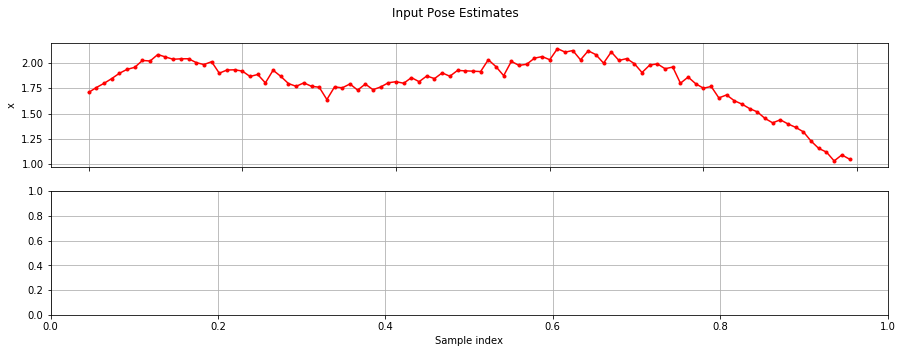

In [292]:
use_toy_data = False

if(use_toy_data):
    # Creating the artificial dataset
    dim1_data = np.arange(0,5.2,0.1)

    for i in range(len(dim1_data)):
        dim1_data[i] += np.random.randn()*0.1

dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()

# Plot subfigures
fig,axs = plt.subplots(2,figsize=(15,5))
fig.suptitle('Input Pose Estimates')
axs[0].plot(dim1_data,'r.-')
axs[0].set(ylabel = 'x')

for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [293]:
# For the two frame case, input tensor holds x, y, and theta data in frame 1, frame 2
# [x1,y1,th1,x2,y2,th2]
# These are offset, so that x1 goes up until the second last frame
# (current frame is treated as future prediction)

# output tensor holds single frame, for x, y, and theta values
# This is cropped to exclude the first n frames (n=2 here) and run up until the end
# So a synthesised 'future' value to aim for

t_x = torch.tensor(dim1_data_scaled)

x_data = torch.zeros(len(dim1_data)-num_frames,input_size)
start_idx = 0
end_idx = len(x_data)
frame_idx = num_frames - 1

for i in range(num_frames):
    x_data[:,frame_idx*num_features] = t_x[start_idx:end_idx]
    start_idx+=1
    end_idx+=1
    frame_idx-=1 # older frames are assigned to later columns
    
y_data = torch.zeros(len(dim1_data)-num_frames,output_size)
y_data[:,0] = t_x[num_frames:]

In [294]:
x_rows = x_data.size()[0]
train_validate_ratio = 0.8
training_idx_limit = int(train_validate_ratio * x_rows)

x_train = x_data[:training_idx_limit,:]
x_valid = x_data[training_idx_limit:,:]

y_train = y_data[:training_idx_limit,:]
y_valid = y_data[training_idx_limit:,:]

print('x_data dimensions:',x_data.size())
print('x_train dimensions:',x_train.size())
print('x_valid dimensions:',x_valid.size())
print('y_data dimensions:',y_data.size())
print('y_train dimensions:',y_train.size())
print('y_valid dimensions:',y_valid.size())

x_data dimensions: torch.Size([98, 2])
x_train dimensions: torch.Size([78, 2])
x_valid dimensions: torch.Size([20, 2])
y_data dimensions: torch.Size([98, 1])
y_train dimensions: torch.Size([78, 1])
y_valid dimensions: torch.Size([20, 1])


In [295]:
class Pose_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)
    
epochs = 10
lr = 0.2
batch_size = 10

model = Pose_Logistic()
criterion = nn.MSELoss()
Loss = []  # variable for storing losses after each epoch

train_ds = TensorDataset(x_train,y_train)
valid_ds = TensorDataset(x_valid,y_valid)

def loss_batch(model,loss_func,xb,yb,opt=None):
    loss=loss_func(model(xb),yb)
    
    if opt is not None:
        Loss.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(),len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def get_model():
    model = Pose_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [296]:
loss_func = criterion

train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 1.4119765758514404
1 0.5045005083084106
2 0.26229244470596313
3 0.13855494558811188
4 0.11886508762836456
5 0.14777934551239014
6 0.17484858632087708
7 0.16371004283428192
8 0.2081356793642044
9 0.16147105395793915


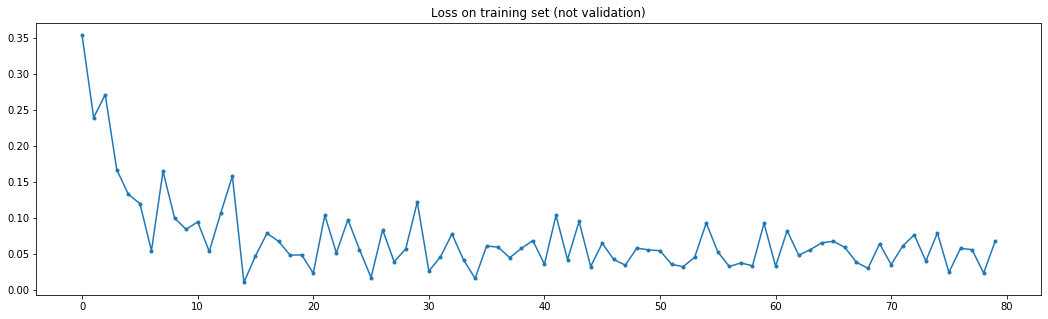

In [297]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set (not validation)")
plt.plot(Loss,'.-')